# Kaggle Spaceship Titanic

### 1. [Data Preprocessing](#Data-Preprocessing)
### 2. [Model Selection & Training](#Model-Selection-&-Training)
### 3. [Model Evaluation](#Model-Evaluation)
### 4. [Prediction](#Prediction)
### 5. [Submission](#Submission)

### Import Modules

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error

from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

#import randomforestregressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, lightgbm, math, itertools

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, GroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

warnings.filterwarnings("ignore")
  
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print('The shape of the training dataset is:', train.shape)
print('The shape of the test dataset is:', test.shape)
train.head()

The shape of the training dataset is: (8693, 14)
The shape of the test dataset is: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


### Check the Shape of Data

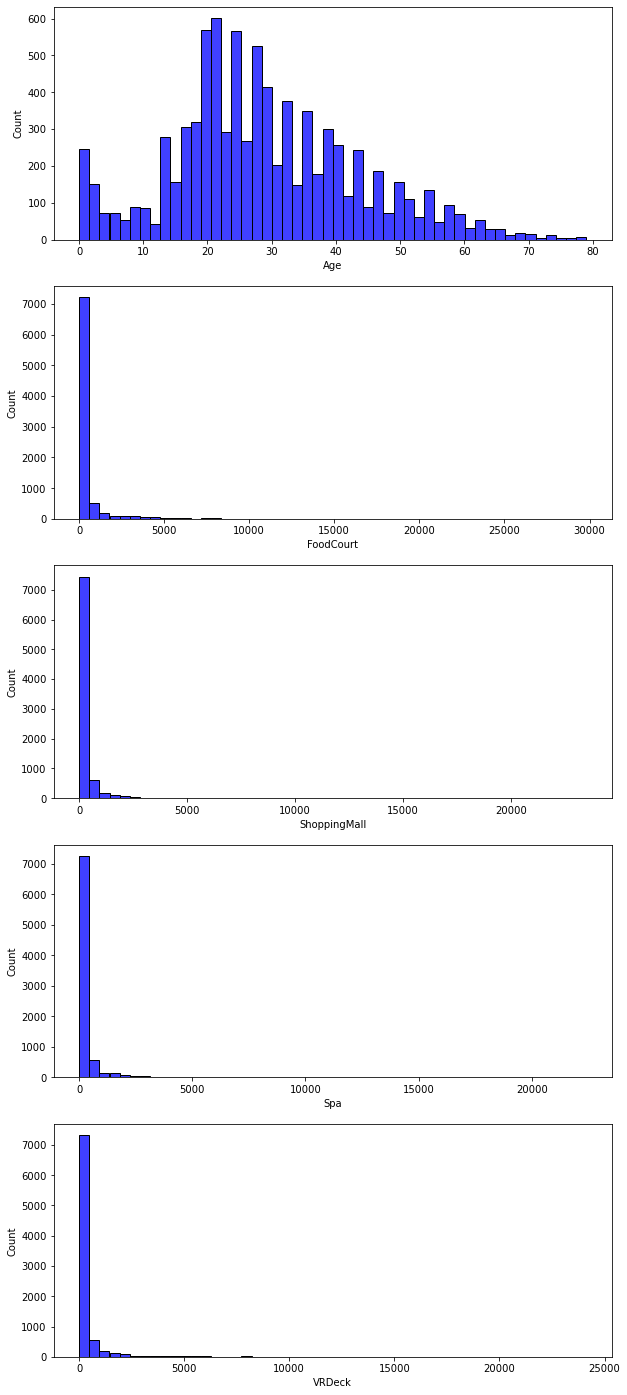

In [2]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(train['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(train['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(train['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(train['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(train['VRDeck'], color='b', bins=50, ax=ax[4]);

1. "HomePlanet" - The planet the passenger departed from, typically their planet of permanent residence.  
2. "CryoSleep" - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.  
3. "Cabin" - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.  
4. "Destination" - The planet the passenger will be debarking to.  
5. "Age" - The age of the passenger.  
6. "VIP" - Whether the passenger has paid for special VIP service during the voyage.  
7. "RoomService", FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.  
8. "Name" - The first and last names of the passenger.  
9. "Transported" - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.  

In [3]:
train = train.drop(columns=["PassengerId","Name"],axis=1)

train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = train[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
train[['Age','RoomService']].fillna(value=train[['Age','RoomService']].mean(), inplace=True)
train.isnull().sum().sort_values(ascending=False)

label = "Transported"
train[label] = train[label].astype(int)
train['VIP'] = train['VIP'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(int)

train[["Deck", "Cabin_num", "Side"]] = train["Cabin"].str.split("/", expand=True)
try:
    train = train.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")
    
TEMP = train["Destination"].value_counts(dropna=False)
train["Destination"] = train["Destination"].fillna(TEMP.index[0])
TEMP = train["Deck"].value_counts(dropna=False)
train["Deck"] = train["Deck"].fillna(TEMP.index[0])
TEMP = train["Side"].value_counts(dropna=False)
train["Side"] = train["Side"].fillna(TEMP.index[0])
TEMP = train["HomePlanet"].value_counts(dropna=False)
train["HomePlanet"] = train["HomePlanet"].fillna(TEMP.index[0])
train["Age"] = train["Age"].fillna(train["Age"].mean())
train["RoomService"] = train["RoomService"].fillna(train["RoomService"].mean())

# train["Spent"] = train["RoomService"] + train["FoodCourt"] + train["ShoppingMall"] + train["Spa"] + train["VRDeck"]
# train = train.drop(columns=["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"],axis=1)

features = ["HomePlanet", "Destination", "Deck", "Side"]
TEMP = pd.get_dummies(train[features])
#add TEMP to train dataframe
train = pd.concat([train, TEMP], axis=1)
train.drop(features, axis=1, inplace=True)

# train["Spent"] = preprocessing.normalize([train["Spent"]])[0]
train['FoodCourt'] = preprocessing.normalize([train['FoodCourt']])[0]
train['ShoppingMall'] = preprocessing.normalize([train['ShoppingMall']])[0]
train['Spa'] = preprocessing.normalize([train['Spa']])[0]
train['VRDeck'] = preprocessing.normalize([train['VRDeck']])[0]
train.columns

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Cabin_num', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S'],
      dtype='object')

### Check nan Values

In [4]:
train.isnull().sum().sort_values(ascending=False)

Cabin_num                    199
CryoSleep                      0
Destination_PSO J318.5-22      0
Side_P                         0
Deck_T                         0
Deck_G                         0
Deck_F                         0
Deck_E                         0
Deck_D                         0
Deck_C                         0
Deck_B                         0
Deck_A                         0
Destination_TRAPPIST-1e        0
Destination_55 Cancri e        0
Age                            0
HomePlanet_Mars                0
HomePlanet_Europa              0
HomePlanet_Earth               0
Transported                    0
VRDeck                         0
Spa                            0
ShoppingMall                   0
FoodCourt                      0
RoomService                    0
VIP                            0
Side_S                         0
dtype: int64

### Selected Features

In [5]:
selected_features = ['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Cabin_num', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S']

### Cor relation between Features

In [6]:
cor = train.corr()
cor_target = abs(cor["Transported"])
print(cor_target.sort_values(ascending=False))
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.0]
all_train = train[relevant_features.index]

Transported                  1.000000
CryoSleep                    0.460132
RoomService                  0.242048
Spa                          0.218545
VRDeck                       0.204874
HomePlanet_Europa            0.176916
HomePlanet_Earth             0.168845
Deck_B                       0.144733
Destination_55 Cancri e      0.108722
Deck_C                       0.108193
Side_S                       0.101397
Side_P                       0.101397
Deck_E                       0.097965
Destination_TRAPPIST-1e      0.096319
Deck_F                       0.086360
Age                          0.074249
FoodCourt                    0.045583
VIP                          0.037261
Deck_D                       0.034046
HomePlanet_Mars              0.019544
Deck_G                       0.016269
Deck_T                       0.014568
ShoppingMall                 0.009391
Deck_A                       0.002623
Destination_PSO J318.5-22    0.000092
Name: Transported, dtype: float64


In [7]:
x = all_train[relevant_features.index]
x = x.drop(columns='Transported')
y = all_train['Transported']
model = make_pipeline(StandardScaler(), Ridge(30))
model.fit(x, y)
print('Train:', model.score(x, y))
print("MSE:",mean_squared_error(y, model.predict(x)))

Train: 0.35606216328469087
MSE: 0.16097600394363346


In [8]:
x = all_train[relevant_features.index]
x = x.drop(columns='Transported')
y = all_train['Transported']
X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2)

model = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1))
model.fit(x, y)
print('Train:', model.score(X_train, y_train))
print("MSE:",mean_squared_error(y_train, model.predict(X_train)))
print()
print('Test:', model.score(X_test, y_test))
print("MSE:",mean_squared_error(y_test, model.predict(X_test)))

Train: 0.5027024648137879
MSE: 0.12432067140192207

Test: 0.5208166910177836
MSE: 0.11977106884731922


# Model Selection & Train

In [9]:
def score_model(model, features_used, label=None):
    x = all_train[features_used.index]
    x = x.drop(columns='Transported')
    y = all_train['Transported']
    X_train, X_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.3)
    model.fit(X_train, y_train)
    output = model.predict(X_test)
    print("Model:", label)
    print('Train:', model.score(X_train, y_train))
    print("Test:", model.score(X_test, y_test))
    print('-------------------')

## Classifier

In [22]:
%%time
#Logistic Regression
lreg = LogisticRegression()
score_model(model=lreg,
            features_used=relevant_features,
            label='LogisticRegression')
lreg.fit(X_train, y_train)

#RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rffc_params = {
    'n_estimators': 500,
    'min_samples_leaf': 30,
    'random_state': 0
}

score_model(model=make_pipeline(RandomForestClassifier(**rffc_params)),
            features_used=relevant_features,
            label='Random Forest Classifier')
rffc =  RandomForestClassifier(**rffc_params)

#GradientBoosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gbclf_params = {
    'n_estimators': 500,
    'min_samples_leaf': 30,
    'random_state': 0
}
score_model(model=make_pipeline(GradientBoostingClassifier(**gbclf_params)),
            features_used=relevant_features,
            label='Gradient Boosting Classifier')
gbclf = GradientBoostingClassifier(**gbclf_params)

#Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB

score_model(model=make_pipeline(GaussianNB()),
            features_used=relevant_features,
            label='GaussianNB Classifier')
nbclf = GaussianNB()

#SVM
svc_params = {
    'kernel': 'rbf',
    'C': 1.0,
    'probability': True
}

score_model(model=make_pipeline(SVC(**svc_params)),
            features_used=relevant_features,
            label='SVC Classifier')
svc = SVC(**svc_params)

#AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
abclf_params = {
    'n_estimators': 500,
    'random_state': 0
}
score_model(model=make_pipeline(AdaBoostClassifier(**abclf_params)),
            features_used=relevant_features,
            label='AdaBoost Classifier')
abclf = AdaBoostClassifier(**abclf_params)

Model: LogisticRegression
Train: 0.7298274445357437
Test: 0.7216257668711656
-------------------
Model: Random Forest Classifier
Train: 0.8075595727198028
Test: 0.8009969325153374
-------------------
Model: Gradient Boosting Classifier
Train: 0.8525883319638455
Test: 0.8048312883435583
-------------------
Model: GaussianNB Classifier
Train: 0.7017255546425637
Test: 0.6905674846625767
-------------------
Model: SVC Classifier
Train: 0.6374691865242399
Test: 0.6319018404907976
-------------------
Model: AdaBoost Classifier
Train: 0.8072308956450288
Test: 0.7967791411042945
-------------------
CPU times: user 14.8 s, sys: 203 ms, total: 15 s
Wall time: 15.1 s


## Regressor

In [11]:

#RandomForest Regressor
rf_params = {
    'n_estimators': 300,
    'min_samples_leaf': 30,
    'random_state': 1
}
score_model(model=make_pipeline(RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)),
            features_used=relevant_features,
            label='Random Forest')
rf = RandomForestRegressor(n_estimators=300, min_samples_leaf=30, random_state=1)
rf.fit(X_train, y_train)

#GradientBoosting Regressor
gbr_params = {'n_estimators': 600,
              'max_depth': 4,
              'learning_rate': 0.01,
              'min_samples_leaf': 40 ,
              'max_features': 3}
score_model(model=make_pipeline(GradientBoostingRegressor(**gbr_params, random_state=2)),
            features_used=relevant_features,    
            label='GradientBoostingRegressor')

gbr = GradientBoostingRegressor(**gbr_params, random_state=2)
gbr.fit(X_train, y_train)

#lightGBM Regressor
lgbm_params = {
        'learning_rate': 0.0005,
        'n_estimators': 20000,
        'num_leaves': 7,
        'colsample_bytree': 0.4,
        'subsample': 0.5,
        'subsample_freq': 6,
        'min_child_samples': 25,
    }
score_model(model=lightgbm.LGBMRegressor(**lgbm_params, random_state=1),
            features_used=relevant_features,
            label='LGBM')

lgbm = lightgbm.LGBMRegressor(**lgbm_params, random_state=1)
lgbm.fit(X_train, y_train)

Model: Random Forest
Train: 0.5030078720411502
Test: 0.43573446922429915
-------------------
Model: GradientBoostingRegressor
Train: 0.4706717496134457
Test: 0.43948423118828894
-------------------


GradientBoostingRegressor(learning_rate=0.01, max_depth=4, max_features=3,
                          min_samples_leaf=40, n_estimators=600,
                          random_state=2)

### Ensemble Model for Regression

In [13]:
from sklearn.ensemble import VotingRegressor
#create a dictionary of our models
estimators=[('rf', rf), ('gbr', gbr), ('lgbm', lgbm)]
#create our voting regressor, inputting our models
ensemble = VotingRegressor(estimators)
ensemble.fit(X_train, y_train)
ensemble.score(X_test, y_test)

0.46643024356195095

### Structure of Ensemble Model

In [14]:
ensemble

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(min_samples_leaf=30,
                                                   n_estimators=300,
                                                   random_state=1)),
                            ('gbr',
                             GradientBoostingRegressor(learning_rate=0.01,
                                                       max_depth=4,
                                                       max_features=3,
                                                       min_samples_leaf=40,
                                                       n_estimators=600,
                                                       random_state=2)),
                            ('lgbm',
                             LGBMRegressor(colsample_bytree=0.4,
                                           learning_rate=0.0005,
                                           min_child_samples=25,
                                           n_estimators=20000, num_leaves=7,
                                           random_state=1, subsample=0.5,
                                           subsample_freq=6))])

### Model Evaluation

In [15]:
from sklearn.ensemble import VotingClassifier

vcfr = VotingClassifier(
    estimators=[
        ('rffc', rffc),
        ('lreg', lreg),
        ('nbclf', nbclf),
        ('svc', svc),
        ('gbclf', gbclf),
        ('abclf', abclf)
    ],
    voting='soft',
    weights=[2, 1, 1, 2, 2, 1],
    flatten_transform=True,
    n_jobs=-1,
    verbose=True
)
vcfr.fit(X_train, y_train)
vcfr.score(X_test, y_test)

[Voting] .................... (3 of 6) Processing nbclf, total=   0.0s
[Voting] ..................... (2 of 6) Processing lreg, total=   0.1s


/Users/apple/miniforge3/envs/pyc/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Voting] ..................... (1 of 6) Processing rffc, total=   1.2s
[Voting] .................... (6 of 6) Processing abclf, total=   1.5s
[Voting] .................... (5 of 6) Processing gbclf, total=   2.9s
[Voting] ...................... (4 of 6) Processing svc, total=   7.1s


0.8067855089131685

In [16]:
from sklearn.ensemble import VotingClassifier

vcfrh = VotingClassifier(
    estimators=[
        ('rffc', rffc),
        ('lreg', lreg),
        ('nbclf', nbclf),
        ('svc', svc),
        ('gbclf', gbclf),
        ('abclf', abclf)
    ],
    voting='hard',
)
vcfrh.fit(X_train, y_train)
vcfrh.score(X_test, y_test)

0.7981598619896493

### Structure of VotingClassifier

In [17]:
vcfr

VotingClassifier(estimators=[('rffc',
                              RandomForestClassifier(min_samples_leaf=30,
                                                     n_estimators=500,
                                                     random_state=0)),
                             ('lreg', LogisticRegression()),
                             ('nbclf', GaussianNB()),
                             ('svc', SVC(probability=True)),
                             ('gbclf',
                              GradientBoostingClassifier(min_samples_leaf=30,
                                                         n_estimators=500,
                                                         random_state=0)),
                             ('abclf',
                              AdaBoostClassifier(n_estimators=500,
                                                 random_state=0))],
                 n_jobs=-1, verbose=True, voting='soft',
                 weights=[2, 1, 1, 2, 2, 1])

### Model Prediction

In [18]:
test = pd.read_csv("test.csv")
test = test.drop(columns=["PassengerId","Name"],axis=1)
test[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = test[['VIP', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(value=0)
test[['Age','RoomService']].fillna(value=test[['Age','RoomService']].mean(), inplace=True)
test['VIP'] = test['VIP'].astype(int)
test['CryoSleep'] = test['CryoSleep'].astype(int)
test[["Deck", "Cabin_num", "Side"]] = test["Cabin"].str.split("/", expand=True)
try:
    test = test.drop('Cabin', axis=1)
except KeyError:
    print("Field does not exist")
TEMP = test["Destination"].value_counts(dropna=False)
test["Destination"] = test["Destination"].fillna(TEMP.index[0])
TEMP = test["Deck"].value_counts(dropna=False)
test["Deck"] = test["Deck"].fillna(TEMP.index[0])
TEMP = test["Side"].value_counts(dropna=False)
test["Side"] = test["Side"].fillna(TEMP.index[0])
TEMP = test["HomePlanet"].value_counts(dropna=False)
test["HomePlanet"] = test["HomePlanet"].fillna(TEMP.index[0])
test["Age"] = test["Age"].fillna(test["Age"].mean())
test["RoomService"] = test["RoomService"].fillna(test["RoomService"].mean())
features = ["HomePlanet", "Destination", "Deck", "Side"]
TEMP = pd.get_dummies(test[features])
#add TEMP to train dataframe
test = pd.concat([test, TEMP], axis=1)
test.drop(features, axis=1, inplace=True)

# test["Spent"] = test["RoomService"] + test["FoodCourt"] + test["ShoppingMall"] + test["Spa"] + test["VRDeck"]
# test = test.drop(columns=["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"],axis=1)
# test["Spent"] = preprocessing.normalize([test["Spent"]])[0]

test['FoodCourt'] = preprocessing.normalize([test['FoodCourt']])[0]
test['ShoppingMall'] = preprocessing.normalize([test['ShoppingMall']])[0]
test['Spa'] = preprocessing.normalize([test['Spa']])[0]
test['VRDeck'] = preprocessing.normalize([test['VRDeck']])[0]
test

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_num,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,1,27.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,3,1,...,0,0,0,0,0,0,1,0,0,1
1,0,19.000000,0,0.0,0.000088,0.000000,0.037743,0.000000,4,1,...,0,0,0,0,0,1,0,0,0,1
2,1,31.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,38.000000,0,0.0,0.064802,0.000000,0.002420,0.007027,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,20.000000,0,10.0,0.000000,0.016702,0.000000,0.000000,5,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.000000,0,0.0,0.000000,0.000000,0.000000,0.000000,1496,1,...,0,0,0,0,0,0,1,0,0,1
4273,0,42.000000,0,0.0,0.008251,0.000447,0.000134,0.001730,NaN,1,...,0,0,0,0,0,1,0,0,0,1
4274,1,28.658146,0,0.0,0.000000,0.000000,0.000000,0.000000,296,0,...,0,0,0,1,0,0,0,0,1,0
4275,0,28.658146,0,0.0,0.026108,0.000000,0.000000,0.006283,297,0,...,0,0,0,1,0,0,0,0,1,0


In [19]:
test.isnull().sum().sort_values(ascending=False)

Cabin_num                    100
CryoSleep                      0
Destination_PSO J318.5-22      0
Side_P                         0
Deck_T                         0
Deck_G                         0
Deck_F                         0
Deck_E                         0
Deck_D                         0
Deck_C                         0
Deck_B                         0
Deck_A                         0
Destination_TRAPPIST-1e        0
Destination_55 Cancri e        0
Age                            0
HomePlanet_Mars                0
HomePlanet_Europa              0
HomePlanet_Earth               0
VRDeck                         0
Spa                            0
ShoppingMall                   0
FoodCourt                      0
RoomService                    0
VIP                            0
Side_S                         0
dtype: int64

### Submission

In [20]:
p = pd.read_csv('test.csv')
x = test[relevant_features.index.drop('Transported')]
predictions = ensemble.predict(x)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': p.PassengerId,
                       'Transported': n_predictions.squeeze()})

output.head()
output.to_csv('vr-submission.csv', index=False)

In [21]:
p = pd.read_csv('test.csv')
x = test[relevant_features.index.drop('Transported')]
predictions = vcfr.predict(x)
n_predictions = (predictions > 0.5).astype(bool)
output = pd.DataFrame({'PassengerId': p.PassengerId,
                       'Transported': n_predictions.squeeze()})

output.head()
output.to_csv('vc-submission.csv', index=False)